# Problem Statement

Millions of people everyday are searching the web for information and anwers. One of the biggest website for forums and discussions is Reddit, holding over 2.8 million different subreddits. Reddit recently has a huge sytem upgrade and during the update millions of reddit post were swithched into incorrect subreddits. Reddit has hired my team to try and classify each reddit post to its correct subreddit. For our trial run we are trying to classify subreddit post between NASA and SpaceX. We purposly picked two subreddits with closely-related post to see how well our model can accurately re-classify the post to their respective subreddit.

# Import Packages

In [243]:
import requests
import json
import csv
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.naive_bayes import MultinomialNB

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer

# Webscraping and Pulling Data

In [210]:
def get_post_json(subreddit, before):
# Setting parameters for the data we are pulling

    url = 'https://api.pushshift.io/reddit/search/submission'
    params = {
        'subreddit': subreddit,
        'size': 100,
    }
    if before is not None:
        params['before'] = before
        
    request = requests.get(url, params)
    return request.json()

#Deciding what columns on the subreddits we are pulling to keep
def consume_post(post):
    data = post['data']
    
    df = pd.DataFrame(data)
    return df[['subreddit', 'id', 'author', 'title', 'selftext', 'created_utc']]

# Since we can only pull 100 subreddit post at a time we have to give it a loop that will continue pulling
# until we reach the quantity we want to pull
def get_post(subreddit, rows):
    posts = set()
    before = None
    x = 0
    while len(posts) < rows:
        batch = get_post_json(subreddit, before)
        df = consume_post(batch)
        before = df['created_utc'].min()
        posts.update(df['id'])
        
        if x == 0:
            header = True
            mode = 'w'
        
        else:
            header = False
            mode = 'a'
        df.to_csv(subreddit + '.csv', mode=mode, header=header, index=False)
        print(f'We have scraped {len(posts)} posts.')
        x+=1
        time.sleep(2)

# Import Data & Reading Data

We are using our program to 5000 post from both NASA and SpaceX subreddit

In [301]:
# pulls reddit post from NASA subreddit
get_post('nasa', 5000)

We have scraped 100 posts.
We have scraped 200 posts.
We have scraped 300 posts.
We have scraped 400 posts.
We have scraped 500 posts.
We have scraped 600 posts.
We have scraped 700 posts.
We have scraped 800 posts.
We have scraped 899 posts.
We have scraped 999 posts.
We have scraped 1099 posts.
We have scraped 1199 posts.
We have scraped 1299 posts.
We have scraped 1399 posts.
We have scraped 1499 posts.
We have scraped 1599 posts.
We have scraped 1699 posts.
We have scraped 1799 posts.
We have scraped 1899 posts.
We have scraped 1999 posts.
We have scraped 2099 posts.
We have scraped 2199 posts.
We have scraped 2299 posts.
We have scraped 2399 posts.
We have scraped 2499 posts.
We have scraped 2599 posts.
We have scraped 2699 posts.
We have scraped 2799 posts.
We have scraped 2899 posts.
We have scraped 2999 posts.
We have scraped 3097 posts.
We have scraped 3197 posts.
We have scraped 3296 posts.
We have scraped 3394 posts.
We have scraped 3494 posts.
We have scraped 3594 posts.
We

In [302]:
# pulls reddit post from SpaceX subreddit
get_post('spacex', 5000)

We have scraped 100 posts.
We have scraped 199 posts.
We have scraped 299 posts.
We have scraped 399 posts.
We have scraped 499 posts.
We have scraped 599 posts.
We have scraped 699 posts.
We have scraped 799 posts.
We have scraped 899 posts.
We have scraped 999 posts.
We have scraped 1099 posts.
We have scraped 1199 posts.
We have scraped 1299 posts.
We have scraped 1399 posts.
We have scraped 1499 posts.
We have scraped 1599 posts.
We have scraped 1698 posts.
We have scraped 1798 posts.
We have scraped 1898 posts.
We have scraped 1998 posts.
We have scraped 2098 posts.
We have scraped 2198 posts.
We have scraped 2298 posts.
We have scraped 2398 posts.
We have scraped 2498 posts.
We have scraped 2598 posts.
We have scraped 2698 posts.
We have scraped 2798 posts.
We have scraped 2898 posts.
We have scraped 2998 posts.
We have scraped 3098 posts.
We have scraped 3198 posts.
We have scraped 3298 posts.
We have scraped 3398 posts.
We have scraped 3498 posts.
We have scraped 3598 posts.
We

We have now pulled 5000 post from the two subreddits, now we have to turn them into dataframes

In [252]:
nasa = pd.read_csv('./data/nasa.csv')
spacex = pd.read_csv('./data/spacex.csv')

# Data Cleaning

Dropping selftext columns from both dataframes, had over 2000 missing rows and I believe it would not make that much of a difference because of the null values.

In [253]:
nasa.drop(columns='selftext', inplace=True)

In [254]:
spacex.drop(columns='selftext', inplace=True)

In [255]:
# merging nasa and spacex dataframe into one giant dataframe
nasa_spacex_data = pd.concat([nasa, spacex])

nasa_spacex_data.to_csv('./data/nasa_spacex_data.csv', index=False)

In [256]:
nasa_spacex = pd.read_csv('./data/nasa_spacex_data.csv')

In [257]:
#lowering words in title column
nasa_spacex['title'] = nasa_spacex['title'].str.lower()

### Lemmatizer and Stemming

We will tokenize the titles in the dataframe to make it easier to work with, stemming & lemmantizing will group together the different inflected forms of a word.

In [258]:
tokenizer = RegexpTokenizer(r'[a-z]\w+')

nasa_spacex['title'] = nasa_spacex['title'].transform(tokenizer.tokenize)

In [259]:
p_stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [260]:
for token_list in nasa_spacex['title']:
    [p_stemmer.stem(i) for i in token_list]
    [lemmatizer.lemmatize(i) for i in token_list]
nasa_spacex['title'] = nasa_spacex['title'].map(lambda x: ' '.join(x))

In [261]:
nasa_spacex = nasa_spacex[~nasa_spacex['title'].str.contains('http')]

## Data Dictionary 

|Feature|Type|Description|
|---|---|---|
|**subreddit**|*obj*|Identifies what subreddit the post came from, NASA or SpaceX.| 
|**id**|*obj*|Identifies the post that was submitted.|
|**author**|*obj*|Identifies the author who submitted the post to that specific subreddit.| 
|**title**|*obj*| The title of the subreddit post.
|**created_utc**|*int64*|Identifies the time and date the subreddit post was posted.| 
|**title_length**|*int64*|Lenght of title by characters in the title.| 
|**title_wordcount**|*int64*|Length of title by word count.| 

# EDA

Creating two new columns that will give us the length and wordcount per titles in the subreddit post. With this information we can see if one post more commonly uses longer post or words. This could help differentiate between NASA subreddit and SpaceX subreddit.

In [262]:
nasa_spacex['title_length'] = nasa_spacex['title'].transform(len)

In [263]:
nasa_spacex['title_wordcount'] = nasa_spacex['title'].map(lambda x: len(x.split(' ')))

In [264]:
nasa_spacex.describe()

,created_utc,title_length,title_wordcount
count,1.013600e+04,10136.000000,10136.000000
mean,1.633379e+09,66.851914,11.281669
std,1.042553e+07,48.269684,8.313925
min,1.614862e+09,0.000000,1.000000
25%,1.624009e+09,36.000000,6.000000
50%,1.632756e+09,56.000000,9.000000
75%,1.642257e+09,78.000000,13.000000
max,1.652469e+09,297.000000,59.000000


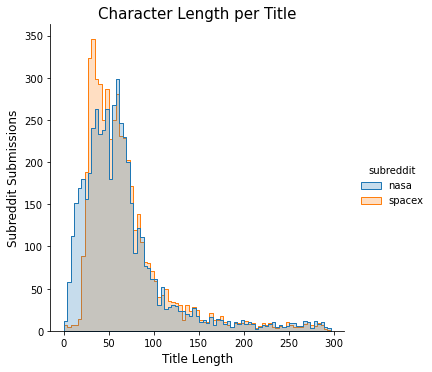

In [265]:
sns.displot(nasa_spacex, x="title_length", hue="subreddit", element="step")
plt.title('Character Length per Title',fontsize=15)
plt.xlabel('Title Length', fontsize=12)
plt.ylabel('Subreddit Submissions', fontsize=12);

Here we can see that spacex has a longer title length by character count. The largest posts character lenght was 297 characters with a mean of 67.

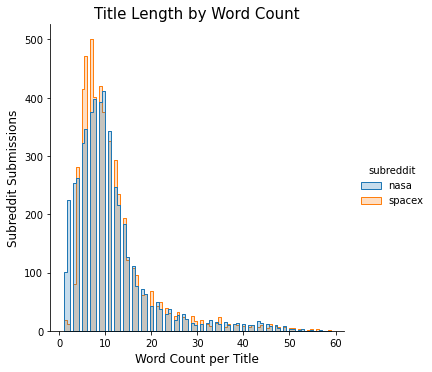

In [266]:
sns.displot(nasa_spacex, x="title_wordcount", hue="subreddit", element="step")
plt.title('Title Length by Word Count', fontsize=15)
plt.xlabel('Word Count per Title', fontsize=12)
plt.ylabel('Subreddit Submissions', fontsize=12);

In both word count and character length charts we can see that the SpaceX subreddit has a higher count but not by much. With the word count graph we can see that spacex has the largest title with 59 words and there was a mean of 11 words.

In [267]:
def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    plt.bar(x,y)

In [268]:
plot_top_stopwords_barchart(nasa_spacex['title'])
plt.title('Top Common Stop Words', fontsize=(15))
plt.xlabel('Stop Word', fontsize=12)
plt.ylabel('Number of times used', fontsize=12);

AttributeError: 'set' object has no attribute 'words'

These are the top 10 most common stop words used in both post that we will remove when modeling our data so that we dont confuse crossover words with these words.

### Word Clouds

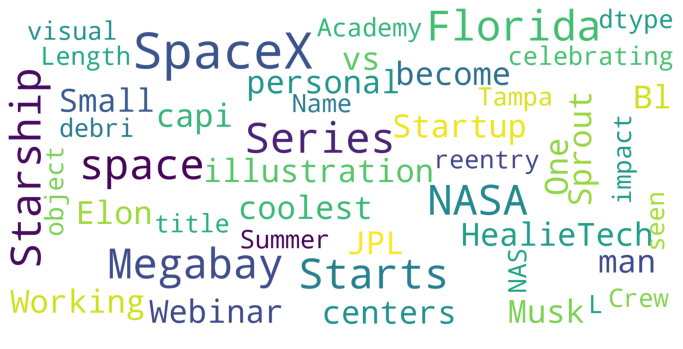

In [337]:
stopwords = set(STOPWORDS)
data_nasa = nasa['title']
def show_wordcloud(data_nasa):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=300,
        max_font_size=30,
        scale=4,
        random_state=1)
   
    wordcloud=wordcloud.generate(str(data_nasa))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(data_nasa)

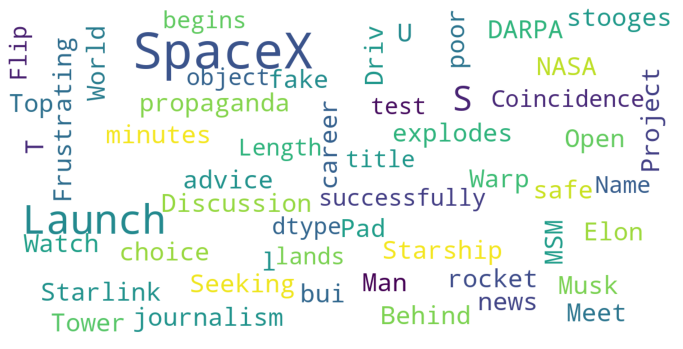

In [334]:
stopwords = set(STOPWORDS)
data_spacex = spacex['title']
def show_wordcloud(data_spacex):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=300,
        max_font_size=30,
        scale=3,
        random_state=1)
   
    wordcloud=wordcloud.generate(str(data_spacex))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(data_spacex)

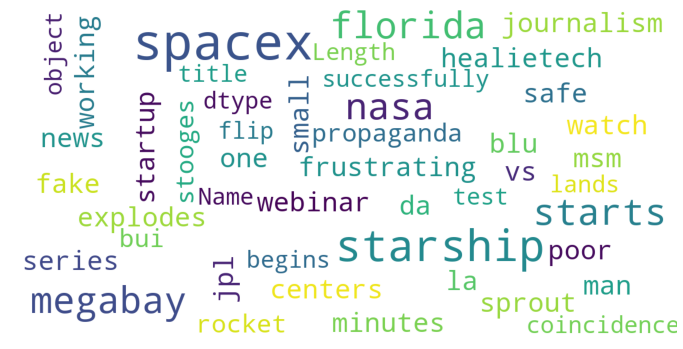

In [336]:
stopwords = set(STOPWORDS)
data_nasaspacex = nasa_spacex['title']
def show_wordcloud(data_nasaspacex):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)
   
    wordcloud=wordcloud.generate(str(data_nasaspacex))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(data_nasaspacex)

I decided to do a world cloud so i can get a better idea on which words were going to be the most commonly used in the NASA subreddit, SpaceX subreddit, and the combined dataframe with both subreddits. As expected, the nasa subreddits most common word was nasa, and the spacex subreddits most common word was spacex. The only thing I found a bit strange was how common spacex was used in the NASA subreddit.

### EDA Analysis

Going through the EDA process we learned that spacex title word and character count were longer than nasa. The obvious most common words were spacex and nasa but also has many similarities like moon, mars, launch, and space. Spacex reddit tends to talk about their founder Elon Musk often so that could be an obvious stand out word to classify for the spacex reddit.

### Count Vectorizer

In [277]:
cvex = CountVectorizer(stop_words='english')
c_data = cvex.fit_transform(nasa_spacex['title'])
c_data = pd.DataFrame(c_data.todense(), columns=cvex.get_feature_names_out())

In [278]:
c_data.sum().sort_values(ascending=False).head(10)

nasa        2339
spacex      1834
space       1635
launch       974
starship     667
elon         655
musk         533
moon         503
mars         475
mission      470
dtype: int64

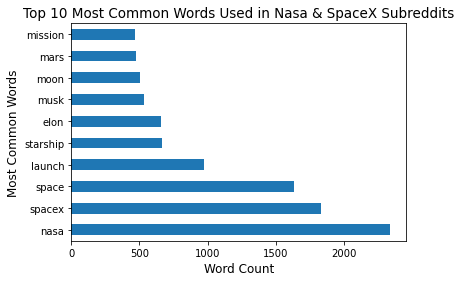

In [279]:
c_data.sum().sort_values(ascending=False).head(10).plot(kind='barh')
plt.xlabel('Word Count', fontsize=12)
plt.ylabel('Most Common Words', fontsize=12)
plt.title('Top 10 Most Common Words Used in Nasa & SpaceX Subreddits', fontsize=13.5);

In [280]:
cvex_nasa = CountVectorizer(stop_words='english')
c_data_nasa = cvex_nasa.fit_transform(nasa['title'])
c_data_nasa = pd.DataFrame(c_data_nasa.todense(), columns=cvex_nasa.get_feature_names_out())

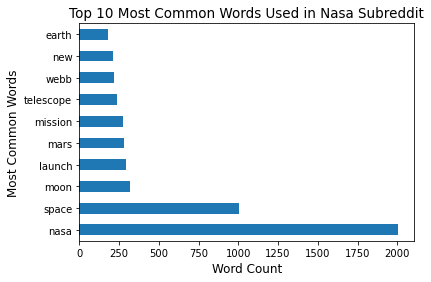

In [281]:
c_data_nasa.sum().sort_values(ascending=False).head(10).plot(kind='barh')
plt.xlabel('Word Count', fontsize=12)
plt.ylabel('Most Common Words', fontsize=12)
plt.title('Top 10 Most Common Words Used in Nasa Subreddit', fontsize=13.5);

In [282]:
cvex_spacex = CountVectorizer(stop_words='english')
c_data_spacex = cvex_spacex.fit_transform(spacex['title'])
c_data_spacex = pd.DataFrame(c_data_spacex.todense(), columns=cvex_spacex.get_feature_names_out())

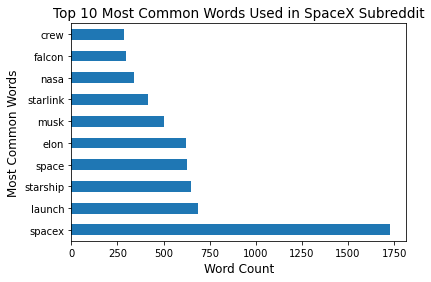

In [283]:
c_data_spacex.sum().sort_values(ascending=False).head(10).plot(kind='barh')
plt.xlabel('Word Count', fontsize=12)
plt.ylabel('Most Common Words', fontsize=12)
plt.title('Top 10 Most Common Words Used in SpaceX Subreddit', fontsize=13.5);

### TFIDF Vectorizer

In [284]:
tvec = TfidfVectorizer(max_df=800, min_df=1, stop_words='english')

tvec_nasa_spacex = tvec.fit_transform(nasa_spacex['title'])

In [285]:
tvec_nasa_spacex = pd.DataFrame(tvec_nasa_spacex.todense(), columns=tvec.get_feature_names_out())

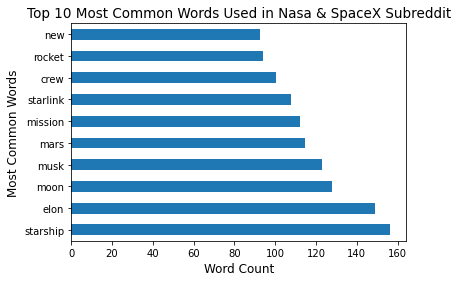

In [286]:
tvec_nasa_spacex.sum().sort_values(ascending=False).head(10).plot(kind='barh')
plt.xlabel('Word Count', fontsize=12)
plt.ylabel('Most Common Words', fontsize=12)
plt.title('Top 10 Most Common Words Used in Nasa & SpaceX Subreddit', fontsize=13.5);

#### CountVectorizer and TFIDFVectorizer Conclusions:

When analysing the top 10 words in the combined NASA/SpaceX subreddit dataframe, I noticed that the top 10 words from the count vectorizer and the top 10 words from the TFIDF Vectorizer were slightly different. It removed nasa, spacex, space, and launch that were the top 4 on the list and instead made starship, elon, moon, and musk the top most common words. In my opinion, The TFIDF is doing a better job by removing the obvious words that could cause more confusion because of the high cross over and keeping words that could help identify the subreddit post. Nasa, spacex, space, are used over 1500 times in the post that were pulled, so they could cause a problem.

# MODELING

### TRAIN TEST SPLIT

In [287]:
# using the title as the X to identify the subreddit post y.
X = nasa_spacex['title']
y = nasa_spacex['subreddit']

In [288]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=13,
    test_size=0.3,
    stratify=y)

#### Count Vectorizer/ Logistic Regression

In [289]:
pipe1 = Pipeline([
    ('cvec', CountVectorizer()),
    ('logreg', LogisticRegression())
])

In [290]:
# how the model will perform with unseen data
cross_val_score(pipe1, X_train, y_train, cv=3).mean()

0.8219873150105709

In [291]:
# fitting model and train accuracy
pipe1.fit(X_train, y_train)

pipe1.score(X_train, y_train)

0.951937984496124

In [292]:
# test accuracy
pipe1.score(X_test, y_test)

0.829003617231174

In [293]:
pipe1_params = {
    'cvec__max_features': [5_000],
    'cvec__min_df': [1],
    'cvec__max_df': [.95],
    'cvec__ngram_range': [(1,1)]
}

In [294]:
# With the way this GridSearchCV is set up we are fitting 160 models
gs = GridSearchCV(pipe1,
                 param_grid=pipe1_params,
                 cv=5)

In [295]:
gs.fit(X_train, y_train)
print(gs.best_score_)

0.8248062015503876


In [296]:
gs.best_params_

{'cvec__max_df': 0.95,
 'cvec__max_features': 5000,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1)}

In [297]:
# score model on training 
gs.score(X_train, y_train)

0.9360112755461593

In [298]:
# score model on test
gs.score(X_test, y_test)

0.8276882604406445

In [299]:
preds = gs.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

/Users/josedelgadillo/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


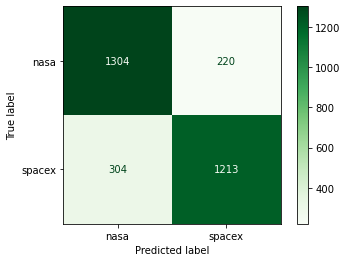

In [300]:
plot_confusion_matrix(gs, X_test, y_test, cmap='Greens', values_format='d');

In [168]:
spec = tn / (tn + fp)

print('Specificity:', spec)

Specificity: 0.8556430446194225


In [301]:
print(f'True negatives: {str(tn)}.' )
print(f'True positives: {str(tp)}.' )
print(f'False negatives: {str(fn)}.' )
print(f'False positives: {str(fp)}.' )

True negatives: 1304.
True positives: 1213.
False negatives: 304.
False positives: 220.


The first model we decided to use Count Vectorizer and Logistic Regression. This gave .82 score on how the model will perform on unseen data. On the training data we scored a .94 and a .83 on the test data. The model is overfit by .11, meaning it does very well with the data we have given it but when introduced with new data it might not work as well.

The confusion matrix is a summary of prediction results on classification problems. This gives us the number of correct and incorrect prediction. We were able to predict 1304 words that were not from the correct subreddit correctly and 1213 that were from the correct subreddit.
The model also predicted 304 post were not in the correct subreddit when it was, and 220 post were in the correct subreddit when it was not.

#### TFIDF Vectorizer/ Logistic Regression

In [302]:
pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logreg', LogisticRegression())
])

In [303]:
pipe_tvec_params = {
    'tvec__max_features': [4_000],
    'tvec__stop_words': ['english'],
    'tvec__ngram_range': [(1,1)]
}

In [304]:
gs_tvec = GridSearchCV(pipe_tvec, 
                        param_grid = pipe_tvec_params,
                        cv=5)

In [305]:
gs_tvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('logreg', LogisticRegression())]),
             param_grid={'tvec__max_features': [4000],
                         'tvec__ngram_range': [(1, 1)],
                         'tvec__stop_words': ['english']})

In [306]:
gs_tvec.best_params_

{'tvec__max_features': 4000,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': 'english'}

In [307]:
# score model on training
gs_tvec.score(X_train, y_train)

0.9088090204369275

In [308]:
# score model on testing
gs_tvec.score(X_test, y_test)

0.833607365998027

In [309]:
preds_tvec = gs_tvec.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, preds_tvec).ravel()

/Users/josedelgadillo/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


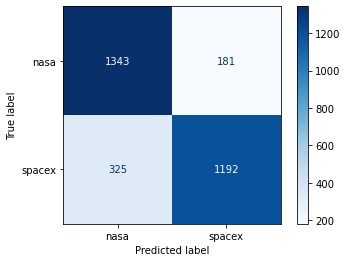

In [310]:
plot_confusion_matrix(gs_tvec, X_test, y_test, cmap='Blues', values_format='d');

In [311]:
spec = tn / (tn + fp)

print('Specificity:', spec)

Specificity: 0.881233595800525


In [312]:
print(f'True negatives: {str(tn)}.' )
print(f'True positives: {str(tp)}.' )
print(f'False negatives: {str(fn)}.' )
print(f'False positives: {str(fp)}.' )

True negatives: 1343.
True positives: 1192.
False negatives: 325.
False positives: 181.


The second model we decided to use TFIDF and Logistic Regression. On the training data we scored a .91 and a .83 on the test data. The model is overfit by .8, it was a bit better than the first model because it was not as overfitting so it would perform better with new data but was slightly worse on the data trained on.

The confusion matrix showed us that the model was able to predict 1343 words that were not from the correct subreddit correctly and 1192 that were from the correct subreddit.
The model also predicted 325 post were not in the correct subreddit when it was, and 181 post were in the correct subreddit when it was not.

#### Count Vectorizer/ Decision Tree

In [313]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=13,
    test_size=0.3,
    stratify=y)

pipe2 = Pipeline([
    ('cvec', CountVectorizer()),
    ('tree', DecisionTreeClassifier())
])

In [314]:
# cross val score
cross_val_score(pipe2, X_train, y_train, cv=3).mean()

0.7852008456659619

In [315]:
# fit and score on train
pipe2.fit(X_train, y_train)
pipe2.score(X_train, y_train)

0.9881606765327695

In [316]:
# score on test
pipe2.score(X_test, y_test)

0.801381124630056

In [317]:
pipe2_params = {
    'cvec__max_features': [3_000],
    'cvec__min_df': [1],
    'cvec__max_df': [.9],
    'cvec__ngram_range': [(1,1)]
}

In [318]:
gs2 = GridSearchCV(pipe2, 
                  param_grid=pipe2_params,
                  cv=5)
gs2.fit(X_train, y_train)
print(gs.best_score_)

0.8248062015503876


In [319]:
#gs2.best_params_

In [320]:
# score on train
gs2.score(X_train, y_train)

0.9861874559548978

In [321]:
# score on test
gs2.score(X_test, y_test)

0.7934889838868793

/Users/josedelgadillo/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


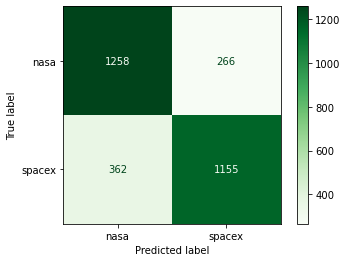

In [322]:
preds2 = gs2.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, preds2).ravel()
plot_confusion_matrix(gs2, X_test, y_test, cmap='Greens', values_format='d');

In [323]:
spec = tn / (tn + fp)

print('Specificity:', spec)

Specificity: 0.8254593175853019


In [324]:
print(f'True negatives: {str(tn)}.' )
print(f'True positives: {str(tp)}.' )
print(f'False negatives: {str(fn)}.' )
print(f'False positives: {str(fp)}.' )

True negatives: 1258.
True positives: 1155.
False negatives: 362.
False positives: 266.


The third model we decided to use count vectorizer and Decision Tree. This gave .78 score on how the model will perform on unseen data. On the training data we scored a .98 and a .79 on the test data. The model is overfit by .19, it does very well with the data we have given it but when introduced with new data it might not work as well.

We were able to predict 1258 words that were not from the correct subreddit correctly and 1155 that were from the correct subreddit.
The model also predicted 362 post were not in the correct subreddit when it was, and 266 post were in the correct subreddit when it was not.

#### TFIDF with Decision Tree

In [325]:
pipe2_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('tree', DecisionTreeClassifier())
])

pipe2_tvec_params = {
    'tvec__max_features': [4_000],
    'tvec__stop_words': ['english'],
    'tvec__ngram_range': [(1,1)]
}

gs_tvec2 = GridSearchCV(pipe2_tvec, 
                        param_grid = pipe2_tvec_params,
                        cv=5)

# fit model
gs_tvec2.fit(X_train, y_train)

# best parameters
gs_tvec2.best_params_

{'tvec__max_features': 4000,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': 'english'}

In [326]:
# score on train
gs_tvec2.score(X_train, y_train)

0.9829457364341085

In [327]:
# score on test
gs_tvec2.score(X_test, y_test)

0.7918447878987175

/Users/josedelgadillo/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


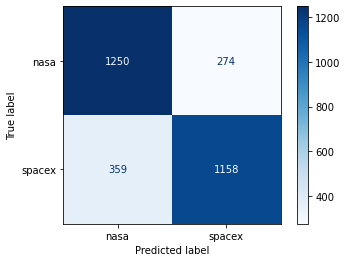

In [328]:
preds_tvec2 = gs_tvec2.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, preds_tvec2).ravel()

plot_confusion_matrix(gs_tvec2, X_test, y_test, cmap='Blues', values_format='d');

In [329]:
spec = tn / (tn + fp)

print('Specificity:', spec)

Specificity: 0.8202099737532809


In [330]:
print(f'True negatives: {str(tn)}.' )
print(f'True positives: {str(tp)}.' )
print(f'False negatives: {str(fn)}.' )
print(f'False positives: {str(fp)}.' )

True negatives: 1250.
True positives: 1158.
False negatives: 359.
False positives: 274.


The fourth model we decided to use TFIDF and Decision Tree. On the training data we scored a .98 and a .79 on the test data. The model is overfit by .19, it performed almost perfect with the data that we trianed it with but a .19 overfit means we would definitly have trouble with any new data.

The confusion matrix showed us that the model was able to predict 1250 words that were not from the correct subreddit correctly and 1158 that were from the correct subreddit.
The model also predicted 359 post were not in the correct subreddit when it was, and 274 post were in the correct subreddit when it was not.

# Conclusion & Next Steps

Between the four separate models, the TFIDF and Logistic Regression model would be the best choise. It did not have the best score on the training data or the test data but it had the least amount of overfitting and the testing data was only a 2 points down from the highest one. This model till had an 8% overfitting but would be the best choice between the other three, with the TFIDF and Decision Tree model having at 19% overfitting. I did try tuning the models a bit but that was the parameters to pick.

How I would proceed if their was more time is i would try different iterations of models (KNNeighbors, MultinomialNB, ect.) and see if there are better models that could transform and evaluate the data. I would focus on finding a model that has a higher test score and a lower overfitting score because of the task. Once we introduce thousands of other reddit post we want the model to be more fluid and classify other post that were not seen.